In [1]:
"""
Scott Lewis
Machine Learning
Semester Project
"""

'\nScott Lewis\nMachine Learning\nSemester Project\n'

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [21]:
# Swiss army knife function to organise the data
def encode(train, test):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species names
    classes = list(le.classes_)                    
    test_ids = test.id                             
    
    train = train.drop(['species', 'id'], axis=1)  
    test = test.drop(['id'], axis=1)
    
    return train, labels, test, test_ids, classes

# Function to find optimal C and gamma hyperparameters for SVC classifier
def svc_param_selection(x, y, nfolds):
    Cs = [0.01, 0.1, 1, 10]
    gammas = ['auto', 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(x, y)
    return grid_search.best_params_

train, labels, test, test_ids, classes = encode(train, test)
train.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [22]:
cv = StratifiedShuffleSplit(test_size=0.2, train_size=0.8, random_state=42)
sss= cv.split(train, labels)

for train_index, test_index in sss:
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [23]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
svc = SVC(kernel="rbf", C=0.025, probability=True)
bagging = BaggingClassifier(KNeighborsClassifier(3), max_samples=0.8, max_features=0.8)

classifiers = [
    KNeighborsClassifier(3),
    bagging,
    svc,
    SVC(probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
    ]
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

#test accuracy for classifiers, results may vary due to stratified shuffle split in data processing
for c in classifiers: 
    if c == svc:
        #search for optimal parameters
        best_params_dict = svc_param_selection(X_train, y_train, nfolds=5)
        print('best params:', best_params_dict)
        clf = SVC(kernel='rbf', C=best_params_dict['C'], gamma=best_params_dict['gamma'], probability=True)
    else:
        clf = c  
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 90.4040%
Log Loss: 1.572933285163142
BaggingClassifier
****Results****
Accuracy: 90.9091%
Log Loss: 0.7420877268099858
best params: {'C': 10, 'gamma': 1}
SVC
****Results****
Accuracy: 92.9293%
Log Loss: 2.32820081381664
SVC
****Results****
Accuracy: 79.2929%
Log Loss: 4.605214176833177
NuSVC
****Results****
Accuracy: 85.3535%
Log Loss: 2.48637071228733
DecisionTreeClassifier
****Results****
Accuracy: 67.1717%
Log Loss: 11.338487200349565
RandomForestClassifier
****Results****
Accuracy: 90.4040%
Log Loss: 1.107980811099987


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AdaBoostClassifier
****Results****
Accuracy: 3.0303%
Log Loss: 4.574913753229555
GradientBoostingClassifier
****Results****
Accuracy: 56.0606%
Log Loss: 2.4798467870631975
GaussianNB
****Results****
Accuracy: 57.5758%
Log Loss: 14.652824015117687
LinearDiscriminantAnalysis
****Results****
Accuracy: 97.9798%
Log Loss: 0.9006433152209651
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 2.5253%
Log Loss: 33.66658507180697


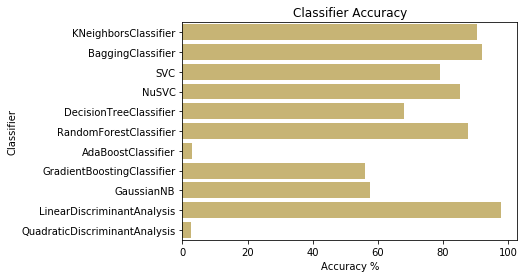

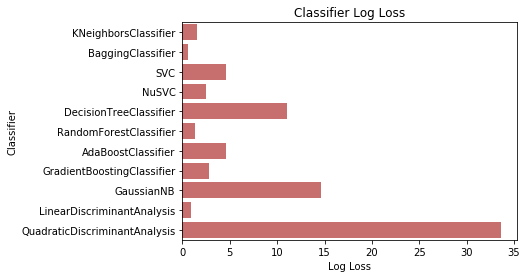

In [8]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="y")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.savefig("Classifiers_Accuracy.png",format='png',bbox_inches='tight',dpi=300)
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="r")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.savefig("Classifiers_Loss.png",format='png',bbox_inches='tight',dpi=300)
plt.show()
